In [1]:
import os
import re
import numpy as np
import csv
import pickle
from sklearn.preprocessing import normalize


In [2]:
all_days=[]
all_stock=[]
for root, directories, filenames in os.walk('./data'):
    for directory in directories:
        #print (directory) #20160210
        #print (os.path.join(root, directory)) #./data/20160210
        if directory not in all_days:
            all_days.append(directory)
    for filename in filenames: 
        #print (filename) #8341.csv
        #print (os.path.join(root,filename)) #./data/20160210/8341.csv
        if filename not in all_stock:
            all_stock.append(filename)
all_days.sort()
print (len(all_days), all_days[:3])
print (len(all_stock), all_stock[:3])

314 ['20150813', '20150817', '20150818']
257 ['8341.csv', '1722.csv', '3037.csv']


In [3]:
choose_stock={'3008.csv':5., '2330.csv': 0.5, '0050.csv': 0.005}

時間, 最近成交價, 當盤成交量, 累積成交量, 最佳五檔（賣價）, 最佳五檔（賣量）, 最佳五檔（買價）, 最佳五檔（買量）

In [4]:

sss=5 #3or5
ttt='average' #'one'or'average'

choose_stock='3008.csv' #2330 or 3008

if choose_stock == '2330.csv':
    if sss == 3:
        sell_range=np.arange(0.5, -2.0, -0.5)
        buy_range=np.arange(-0.5, 2.0, 0.5)

    elif sss == 5:
        sell_range=np.arange(0.5, -3.5, -0.5)
        buy_range=np.arange(-0.5, 3.5, 0.5)

elif choose_stock == '3008.csv':
    if sss == 3:
        sell_range=np.arange(5, -20, -5)
        buy_range=np.arange(-5, 20, 5)

    elif sss == 5:
        sell_range=np.arange(5, -35, -5)
        buy_range=np.arange(-5, 35, 5)
    
x=[]
y=[]
price=[]
price_difference=[]

for day in all_days:
    #print (day)
    x_data_in_one_day=[]
    y_data_in_one_day=[]
    x_buffer=[]
    y_buffer=[]
    price_in_one_day=[]
    price_difference_in_one_day=[]
    with open(os.path.join('./data',day,choose_stock), 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        previous_time='0'
        previous_price=0.0

        for row in spamreader:
            if row[0]==previous_time:
                continue
            else:
                data=[]
                #print (row)
                row[1]=float(row[1])
                row[2]=int(row[2])
                row[4]=list(map(lambda x: row[1]-float(x), filter(None, row[4].split('_'))))
                row[5]=list(map(int, filter(None, row[5].split('_'))))
                row[6]=list(map(lambda x: row[1]-float(x), filter(None, row[6].split('_'))))
                row[7]=list(map(int, filter(None, row[7].split('_'))))

                sell_five=dict(zip(row[4], row[5]))
                buy_five=dict(zip(row[6], row[7]))

                sell_five_vector=[0]*len(sell_range)
                buy_five_vector=[0]*len(buy_range)
                
                for index, i in enumerate(sell_range):
                    try:
                        sell_five_vector[index]=sell_five[float(i)]
                    except KeyError:
                        continue

                for index, i in enumerate(buy_range): 
                    try:
                        buy_five_vector[index]=buy_five[float(i)]
                    except KeyError:
                        continue
                #print (len(sell_five_vector), sell_five_vector)
                #print (len(buy_five_vector), buy_five_vector)

                #data.append(row[1])
                data.append(row[1]-previous_price)
                for s in sell_five_vector:
                    data.append(s)
                for b in buy_five_vector:
                    data.append(b)
                #print (len(data))
   
                x_buffer.append(data) #x=[價差, sell_five_vector, buy_five_vector], len(x)=17
                
                y_buffer.append(row[1]) 
               
        
                if len(x_buffer)==11 and ttt == 'one':
                    x_buffer_copy=list(x_buffer[:10])
                    x_buffer_copy=normalize(x_buffer_copy, axis=0)
                    x_data_in_one_day.append(x_buffer_copy) 
                    y_data_in_one_day.append(str(y_buffer[-1]-y_buffer[-2])) #y是價差
                    price_in_one_day.append(y_buffer[-1])
                    price_difference_in_one_day.append(y_buffer[-1]-y_buffer[-2])
                    del(x_buffer[0])
                    del(y_buffer[0])

                    
                if len(x_buffer)==13 and ttt == 'average':
                    x_buffer_copy=list(x_buffer[:10])
                    x_buffer_copy=normalize(x_buffer_copy, axis=0)
                    x_data_in_one_day.append(x_buffer_copy) 
                    y_data_in_one_day.append(str(sum([j-i for i, j in zip(y_buffer[10:-1], y_buffer[11:])]))) #y是10step總和
                    price_in_one_day.append(y_buffer[-1])
                    price_difference_in_one_day.append(sum([j-i for i, j in zip(y_buffer[10:-1], y_buffer[11:])])) #price_difference_in_ten_days
                    del(x_buffer[0])
                    del(y_buffer[0])

                previous_time=row[0]
                previous_price=row[1]
                
    #print (x_data_in_one_day)
    #print (y_data_in_one_day)
    #print (len(x_data_in_one_day), len(y_data_in_one_day))
    x.extend(x_data_in_one_day)
    y.extend(y_data_in_one_day)
    price.extend(price_in_one_day)
    price_difference.extend(price_difference_in_one_day)

print (len(x), len(y)), len(price)
print (len(x[0]))

print ('{}, {}, {}'.format(choose_stock[:4],sss,ttt))

96075 96075
10
3008, 5, average


In [ ]:
f = open('{}_{}_{}.p'.format(choose_stock[:4],sss,ttt),'wb')
pickle.dump((x,y,price), f)
print ('{}_{}_{}.p saved'.format(choose_stock[:4],sss,ttt))

In [111]:
print (len(x[0][0]))
print (y[-1000:])
print (choose_stock[:4])

17
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '-5.0', '-5.0', '0.0', '0.0', '5.0', '0.0', '0.0', '5.0', '0.0', '0.0', '0.0', '0.0', '0.0', '-5.0', '-5.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '5.0', '-5.0', '-10.0', '0.0', '0.0', '-5.0', '0.0', '0.0', '0.0', '0.0', '5.0', '5.0', '-5.0', '-5.0', '-5.0', '-15.0', '-10.0', '-5.0', '-5.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '5.0', '5.0', '0.0', '0.0', '10.0', '10.0', '0.0', '-5.0', '-5.0', '0.0', '0.0', '5.0', '0.0', '-5.0', '0.0', '5.0', '0.0', '-5.0', '0.0', '0.0', '0.0', '0.0', '15.0', '15.0', '0.0', '0.0', '0.0', '-5.0', '-5.0', '5.0', '0.0', '-5.0', '0.0', '0.0', '0.0', '5.0', '5.0', '0.0', '0.0', '0.0', '5.0', '0.0', '-10.0', '0.0', '10.0', '5.0', '0.0', '5.0', '5.0', '0.0', '0.0', '0.0', '-5.0', '-5.0', '-5.0', '0.0', '5.0', '0.0', '0.0', '-5.0', '-5.0', '0.0', '0.0', '5.0', '0.0', '-10.0', '-5.0', '0.0', '0.0', '0.0', '5.0', '5.0', '-10.0', '-1

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(facecolor='white', figsize=(20, 10))
plt.plot(price, color='b',label='True Data', linewidth=0.5)
plt.show()

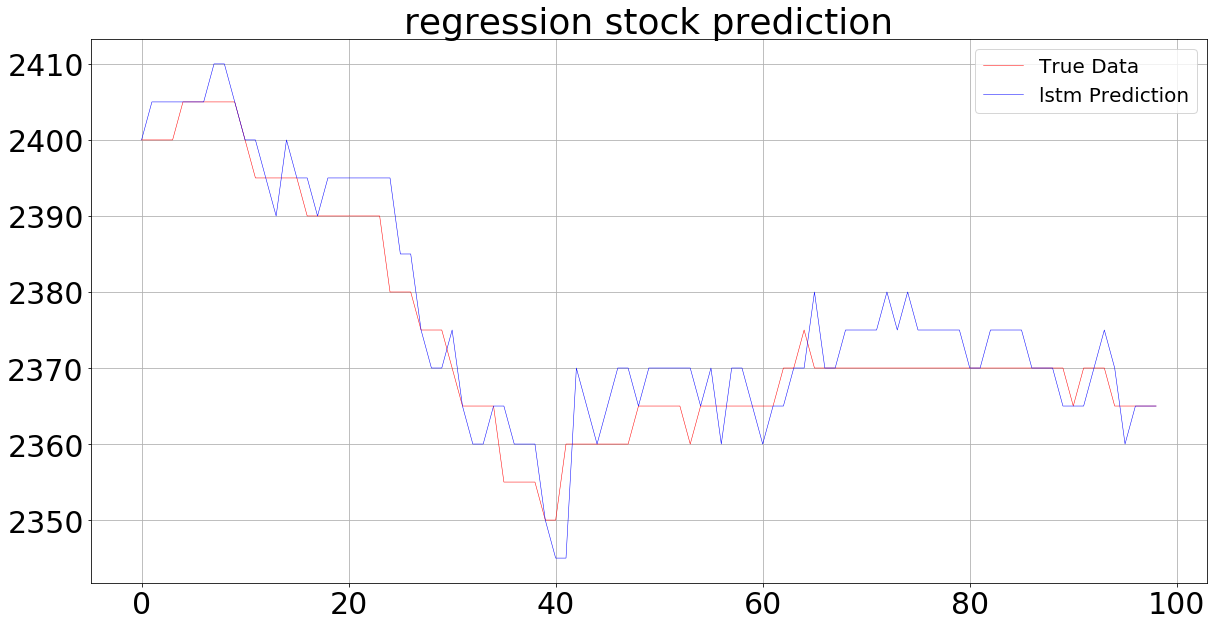

In [13]:
import matplotlib.pyplot as plt
import pickle

stock = choose_stock[:4] #要調要直接調choose_stock
s=3
t=ttt #要調要直接調ttt
model='regression' #CRNN lstm regression
prediction_value=pickle.load(open('{}_{}_{}_{}_prediction.p'.format(stock, model, s, t),'rb'))
#print (prediction_value[:100])
#print (len(prediction_value), len( price[69999:89999]))
predict_price=list(map(lambda x, y :x+y, prediction_value, price[69999:79999]))
#print(len(predict_price))
fig = plt.figure(facecolor='white', figsize=(20, 10))

#price
plt.plot(price[70600:70699], color='r',label='True Data', linewidth=0.5)
plt.plot(predict_price[600:699], color='b',label='lstm Prediction', linewidth=0.5)

plt.rcParams.update({'font.size': 30})
plt.grid(True)
plt.title('{} stock prediction'.format(model))
plt.legend(prop={'size':20})
#plt.show()
plt.savefig('{}_{}_one_price.png'.format(model, s))

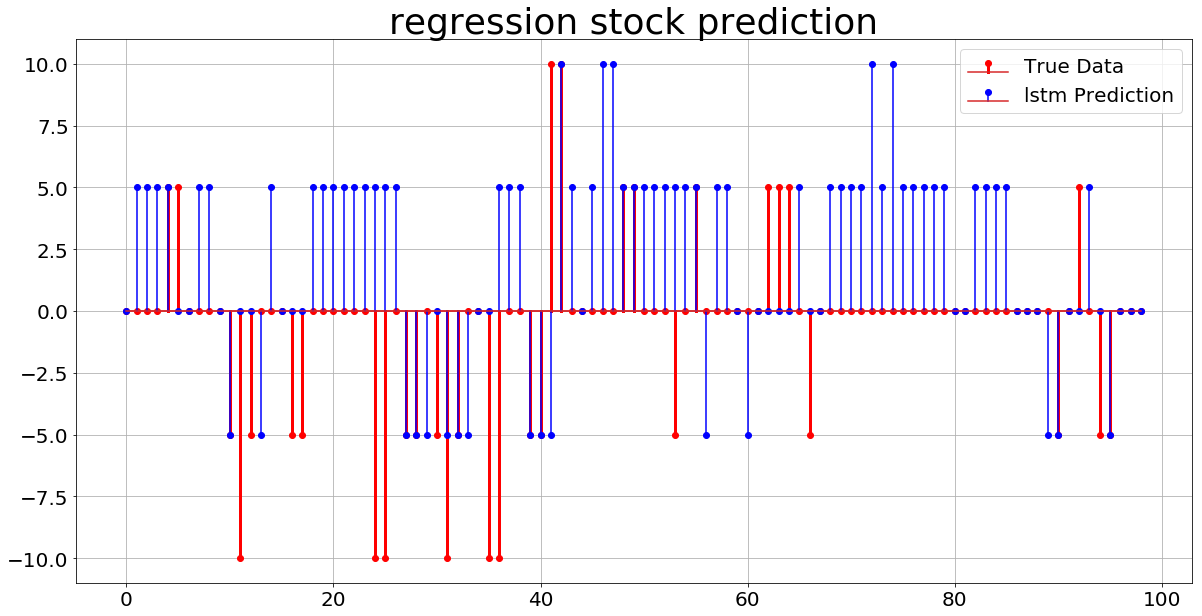

In [12]:
import matplotlib.pyplot as plt
import pickle

#stock = choose_stock[:4]
#s=5
#t='one'
#model='CRNN'
prediction_value=pickle.load(open('{}_{}_{}_{}_prediction.p'.format(stock, model, s, t),'rb'))
#print (prediction_value[:100])
#print (len(prediction_value), len( price[69999:89999]))
predict_price=list(map(lambda x, y :x+y, prediction_value, price[69999:79999]))
#print(len(predict_price))
fig = plt.figure(facecolor='white', figsize=(20, 10))

#price_difference
#print(len(price[70600:70699])), print(len(predict_price[600:699]))
markerline1, stemlines1, baseline1=plt.stem(price_difference[70600:70699],label='True Data', linefmt='r-', markerfmt='ro')
markerline2, stemlines2, baseline2=plt.stem(prediction_value[600:699],label='lstm Prediction', linefmt='b-', markerfmt='bo')
plt.setp(stemlines1, linewidth=3, color='r')
plt.setp(markerline1, linewidth=5, color='r')

plt.rcParams.update({'font.size': 30})
plt.grid(True)
plt.title('{} stock prediction'.format(model))
plt.legend(prop={'size':20})
#plt.show()
plt.savefig('{}_{}_{}_price_difference.png'.format(model, s, t))